In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as pplt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
from gtfparse import read_gtf

In [2]:
variants = pd.read_pickle('03_for_cDNA/vars_prot_ips')
ips_dict = pickle.load(open('00_dataframes/ips_dict', 'rb'))
all_vars = pd.read_pickle('00_dataframes/all_annotated_vars')

In [3]:
def search_col(df, inp):
    return [i for i in df.columns if inp.lower() in (i.lower())]

In [8]:
#variants[['#CHROM', 'pos_last', 'pos_next', 'kind', 'shortcut', 'strand',
#       'HUGO_Symbol', 'RefSeq accession', 'cDNA_len',
#       'termin_prot_len', 'ref_cDNA_len', 'ref_protein_seq_len',
#       'nuc_change_pos', 'prot_change_pos', 'aa_next_pos', 'exons_lengths',
#       'max_exon', 'len_del_ins', 'changed_exon', 'hgsv_pos',
#       'domains_effected', 'domains_deleted']].to_excel('02_output_analysis/variants_aa_pos.xlsx')

### InterProScan dictionary

In [96]:
dom_eff = variants[(variants['domains_effected'].astype(str)!='[]')|(variants['domains_deleted'].astype(str)!='[]')
                  ].copy().reset_index(drop=True)

In [ ]:
# for ips selection: 'where_data_from' --> ProSiteProfiles, MobiDBLite

### UniProt domains

In [18]:
# search for right gene/protein for UniProt ID
with open('uniprot_ids.txt', 'w') as o:
    for i in sorted(set(variants['HUGO_Symbol'])):
        o.write(i+'\n')

In [19]:
# IDs as df
exc_uniprot = pd.read_excel('03_for_cDNA/gene_id_uniprot.xlsx')
exc_uniprot = exc_uniprot.drop(index=[5, 6, 9, 11], columns=['Entry name', 'Status', 'Gene names', 'Organism'])
exc_uniprot = exc_uniprot.rename(columns={'yourlist:M2021091492C7BAECDB1C5C413EE0E0348724B6821DAE3C1':'gene'})

/software/miniconda3/envs/Alexandra_DEV/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [20]:
# gff format of UniProt outcome with domains
gff = pd.read_csv('03_for_cDNA/uniprot_proteins.gff', sep='\t', comment='#', 
                  names=['Entry', 'where_from', 'item', 'start_pos', 'end_pos', 'o0', 'o1', 'o2', 'ids', 'o3'], 
                  usecols=['Entry', 'item', 'start_pos', 'end_pos', 'ids'])
gff = gff[gff['item'].isin(['Domain', 'Nucleotide binding', 'Region', 'Active site', 'Binding site', 'Zinc finger',
                            'Site', 'Metal binding', 'Motif', 'Compositional bias', 'Signal peptide', 'Propeptide', 
                            'Topological domain', 'Transmembrane', 'DNA binding', 'Transit peptide'])]

In [21]:
# merged gene name and domains
up_df = pd.merge(gff, exc_uniprot, on='Entry', how='right')
up_df = up_df.drop_duplicates()
up_df = up_df[up_df['start_pos'].notnull()]
up_df[['start_pos', 'end_pos', 'Length']] = up_df[['start_pos', 'end_pos', 'Length']].astype(int)
up_df['info_domain'] = up_df['ids'].str.split('=', expand=True)[1].str.split(';', expand=True)[0]
up_df = up_df[['gene', 'Entry', 'start_pos', 'end_pos', 'item', 'info_domain', 'Length', 'Protein names', 'ids']]
up_df = up_df.sort_values(by=['gene', 'start_pos', 'end_pos']).reset_index(drop=True)

In [23]:
#up_df.to_pickle('00_dataframes/uniprot_domains')

In [10]:
#pd.read_pickle('00_dataframes/uniprot_domains').to_excel('02_output_analysis/domains_uniprot.xlsx')

### Protein domain analysis

In [5]:
up_df = pd.read_pickle('00_dataframes/uniprot_domains')

### Visualization Exons

In [183]:
def prot_domains(ind, df_var, up_df):
    if ind in df_var.index:
        prot = df_var.iloc[ind]['HUGO_Symbol']
        ips_prot = up_df[up_df['gene']==prot]

        prot_change_pos = df_var.iloc[ind]['prot_change_pos']
        aa_next_pos = df_var.iloc[ind]['aa_next_pos']
        termin_pos = df_var.iloc[ind]['termin_prot_len']

        max_pos = df_var.iloc[ind]['ref_protein_seq_len']

        seq_alt = df_var.iloc[ind]['protein_seq']
        seq_ref = df_var.iloc[ind]['ref_protein_seq']
    
        if type(prot_change_pos)==int:
            try:
                seq_alt = seq_alt[prot_change_pos-10:prot_change_pos+9]
                seq_ref = seq_ref[prot_change_pos-10:prot_change_pos+9]
            except:
                seq_alt = seq_alt[prot_change_pos-10:]
                seq_ref = seq_ref[prot_change_pos-10:]
            seq_match = ''
            for a,r in zip(seq_alt, seq_ref):
                if a==r:
                    seq_match += '|'
                else:
                    seq_match += ' '

            inds = ips_prot.index
            starts = ips_prot['start_pos']
            ends = ips_prot['end_pos']
            ids = ips_prot['info_domain']
            ys = np.arange(0.01,1,1/len(ips_prot))

            fig = plt.subplots(figsize=(14, 6))
            ax1 = plt.subplot(1,1,1)

            plt.ylim([0,1])
            plt.xlim([0,max_pos])
            ax1.get_yaxis().set_visible(False)
            ax1.set_xlabel('amino acid position', fontsize=12)
            ax1.xaxis.set_label_coords(0.5, -0.1)

            ax1.set_title('Protein domains of %s' %prot, fontsize = 18, fontweight = 'bold', loc = 'center')

            for i,s,e,y,t in zip(inds, starts, ends, ys, ids):
                ax1.add_patch(pplt.Rectangle((s, y), e-s, 0.01, fc = 'black', ec = 'black', alpha = 1))
                plt.text(max_pos+5, y, t, size = 13, ha='left')
            if prot_change_pos != 'no_change':
                ax1.add_patch(pplt.Rectangle((prot_change_pos, 0), 0.01, 1, fc = 'green', ec = 'green', alpha = 1))
                if aa_next_pos not in ['probably frameshift', 'error']:
                    ax1.add_patch(pplt.Rectangle((prot_change_pos, aa_next_pos), 0.01, 1, fc = 'green', 
                                                 ec = 'green', alpha = 1))
                    plt.text(x=aa_next_pos, y=-0.07, s='aa substitution', ha='center', c='green')
            
            if aa_next_pos not in ['probably frameshift', 'error']:
                ax1.add_patch(pplt.Rectangle((termin_pos+(aa_next_pos-prot_change_pos), 0), 0.01, 1, fc = 'red', 
                                             ec = 'red', alpha = 1))
                plt.text(x=termin_pos+(aa_next_pos-prot_change_pos), y=-0.07, s='stop', ha='center', c='red')
            elif aa_next_pos == 'probably frameshift':
                ax1.add_patch(pplt.Rectangle((termin_pos, 0), 0.01, 1, fc = 'red', ec = 'red', alpha = 1))
                plt.text(x=termin_pos, y=-0.07, s='stop', ha='center', c='red')
            
            plt.text(x=1, y=0.9, s=seq_alt, size = 15, ha='left', family='monospace')
            plt.text(x=1, y=0.85, s=seq_match, size = 15, ha='left', family='monospace')
            plt.text(x=1, y=0.8, s=seq_ref, size = 15, ha='left', family='monospace')
            plt.gcf().subplots_adjust(bottom = 0.1, top = 0.94, left = 0.01, right = 0.6)
        else:
            print('no change in protein sequence')
    else:
        print('index not in dataframe')

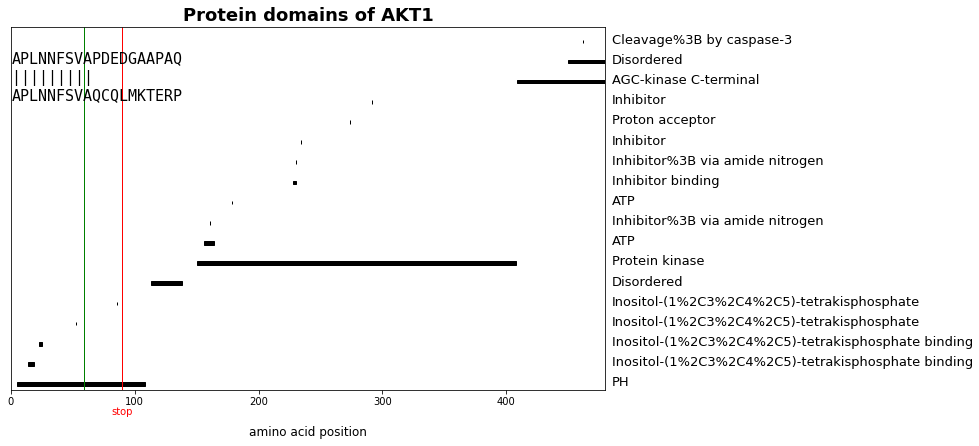

In [184]:
prot_domains(0, variants, up_df)

In [157]:
up_df[up_df['gene']=='XPA']

,gene,Entry,start_pos,end_pos,item,info_domain,Length,Protein names,ids
630,XPA,P23025,4,97,Region,Interaction with CEP164 and required for UV re...,273,DNA repair protein complementing XP-A cells (X...,Note=Interaction with CEP164 and required for ...
631,XPA,P23025,26,47,Motif,Nuclear localization signal,273,DNA repair protein complementing XP-A cells (X...,Note=Nuclear localization signal;Ontology_term...
632,XPA,P23025,105,129,Zinc finger,None,273,DNA repair protein complementing XP-A cells (X...,.


In [139]:
variants.loc[66]

#CHROM                                                                 7
pos_last                                                        66459198
pos_next                                                        66459207
kind                                                                 del
shortcut                                                7_66459197_A_G_0
strand                                                             minus
HUGO_Symbol                                                         SBDS
QCI_ID                                            c.253_258+2delAAGCAGGT
QCI_analysis           likely pathogenic, activity loss, in domain SB...
length_indel                                                           9
RefSeq accession                                               NM_016038
CHR                                                                    7
POS                                                             66459197
REF                                                

In [140]:
variants[['termin_prot_len', 'ref_protein_seq_len', 'prot_change_pos', 'aa_next_pos', 'length_indel']
        ][variants['shortcut']=='7_66459197_A_G_0']

,termin_prot_len,ref_protein_seq_len,prot_change_pos,aa_next_pos,length_indel
66,86,250,84,probably frameshift,9
